In [1]:
#This is an example of the calculation of an optimal control input 
#to a coupled network of FitzHugh-Nagumo oscillators.
#In this example the control task is to switch between predefined bistable states.

#The calculation of this example might take a few minutes.


#!/usr/bin/env python
# coding: utf-8

import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import functions as functions
from FRoptimize import FR_algorithm

import scipy.sparse as sp
import numpy as np
import pickle
import random
seed=50
random.seed(seed)


######################### SET PARAMETERS ############################

#set control goal: 
#can be "sync" (sync all nodes, use cost functional F_1), or "switch" (switch from ones state to a target state, use cost functional F_2
goal='sync'#'switch'
#choose to simulate close to low or high bifurcation of the network dynamics in the state space
#needed for choosing the parameters sigma and mu
bifurcation='low'
#strenght of normalized gaussian white noise
noise_strength= 0.0 
#set network parameters
parameters = functions.set_parameters(goal,bifurcation,parentDir) # set node an network parameters: alpha,beta,gamma,delta,tau,epsilon,sigma,mu,A,N

#set paraeters of the cost functional
I_p_in= 0.0005 #penalize precision
I_e= 1.0 #penalize control energy should be >0
I_s= 0.0#enforce sparsity

#Set dimensions
T= 400 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#if multiple realizations: set realization number
run=0

if goal=='switch':
    #set whether a switch from the low to high state or the opposite should be made
    #can be either 'lowtohigh' or 'hightolow'
    switchfromto='lowtohigh' 
    #the presision is only penalized at the last 25 timeunits, to give the system time to switch
    I_p=np.zeros((tsteps,parameters['N']))
    I_p[int(tsteps-25/dt):]=I_p_in*np.ones((int(25/dt),parameters['N']))
elif goal=='sync':
    switchfromto='none'
    I_p=I_p_in
    
######################### INITIALIZATION ############################

#initialize noise if the noise-strenght is not zero:
if noise_strength !=0.0:
    realizations=20 #number of noise realizations over which to take the mean to calculate the cost functional
    noise=functions.initialize_noise(noise_strength,dt,realizations,tsteps,parameters['N'])
else:
    realizations=1
    noise=0

#choose initial condition for control, should not be 0 if I_s>0
control=-np.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

#Check that parameters are chosen correctly
functions.check_parameters(goal,bifurcation,switchfromto,noise_strength,I_p_in,I_e,I_s,control.reshape(tsteps,parameters['N']))

#initialize the node acivity and set target output
if goal=='sync': 
    # uuse random node inis
    node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)
    #target output is a cross correlation of one for all pairs of nodes equal to one
    target_output=np.ones((parameters['N'],parameters['N']))

elif goal=='switch':  
    #read node inis from file, target_output is the state we want to switch to
    node_ic,target_output=functions.read_node_inis_from_file(bifurcation,switchfromto,fileDir,tsteps,d,dt,parameters)



#make dictionary with all parameters
args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)


######################### OPTIMIZATION ############################
#define the functional and its gradient
if noise_strength==0.0:
    if goal=='switch':
        functional=functions.f_switch
        gradient=functions.fprime_switch
    elif goal=='sync':
        functional=functions.f_sync
        gradient=functions.fprime_sync
else:
    functional=functions.f_sync_noisy
    gradient=functions.fprime_sync_noisy
    
    
#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
while warnflag == 1 and iteration<5000:
    
    result = FR_algorithm(functional, control, gradient,**args)

    control=result[0]
    warnflag=result[2]
    iteration+=result[4]
    
    #make dictionary to save the result
    out={
        'optimal_control':control.reshape(tsteps,parameters['N']),
        'functional':result[1],
        'gradient_norm':result[3],
        'warnflag':result[2],
        'iterations':iteration,
        'node_ic':node_ic,
        'target_output':target_output,
        'external_current':parameters['mu'],
        'coupling_strength':parameters['sigma'],
        'noise_strength':noise_strength,
        'noise':noise,
        'I_p':I_p,
        'I_e':I_e,
        'I_s':I_s,
        'T':T,
        'bifurcation':bifurcation,
        'goal':goal
        }
    
    print('Iteration ',iteration,' finished at gnorm',result[3],'with f',result[1],'with warnflag',result[2])


 #   outfile = open('filename','wb')
  #  pickle.dump(out,outfile)   
   # outfile.close()

print('Code finished after ',iteration,' iterations with warnflag',result[2])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Maximal iteration of FR algorithm reached.
Iteration  250  finished at gnorm 0.0028046991556422564 with f 0.1525053685142036 with warnflag 1
Maximal iteration of FR algorithm reached.
Iteration  500  finished at gnorm 0.0009957694847077666 with f 0.13590272493968364 with warnflag 1
Maximal iteration of FR algorithm reached.
Iteration  750  finished at gnorm 0.0029290498439807147 with f 0.1271563107238638 with warnflag 1
Maximal iteration of FR algorithm reached.
Iteration  1000  finished at gnorm 0.004185566931731448 with f 0.11829485733161631 with warnflag 1
Maximal iteration of FR algorithm reached.
Iteration  1250  finished at gnorm 0.0013754414146238255 with f 0.11310075940262149 with warnflag 1
Maximal iteration of FR algorithm reached

In [3]:
result[5]

[0.07689396823045647,
 0.07689387242260232,
 0.0768938724226018,
 0.07689371880555247,
 0.07689371880555229,
 0.0768936316461364,
 0.07689363164613591,
 0.0768934964417298,
 0.07689341421952507,
 0.07689333269372603,
 0.07689322118344523,
 0.07689257671131948,
 0.07689249566953948,
 0.07689213599475324,
 0.0768920508312326,
 0.07689158451940142,
 0.07689150595570357,
 0.07689102879368259,
 0.07689096608551321,
 0.07689069044785278,
 0.07689063042070386,
 0.07689040932166863,
 0.07689034227314624,
 0.07689007813502802,
 0.07688999130271544,
 0.0768899090445148,
 0.07688974758569714,
 0.07688865985198165,
 0.07688858983143651,
 0.07688833781214045,
 0.07688824415196904,
 0.07688821188032012,
 0.0768880442576028,
 0.0768868708737133,
 0.07688681710694248,
 0.07688651354993303,
 0.07688646398559411,
 0.07688615411554678,
 0.07688611242580043,
 0.07688595399650454,
 0.07688591266248916,
 0.0768858100454528,
 0.07688576397968394,
 0.07688566341132314,
 0.07688562108443824,
 0.076885532724277

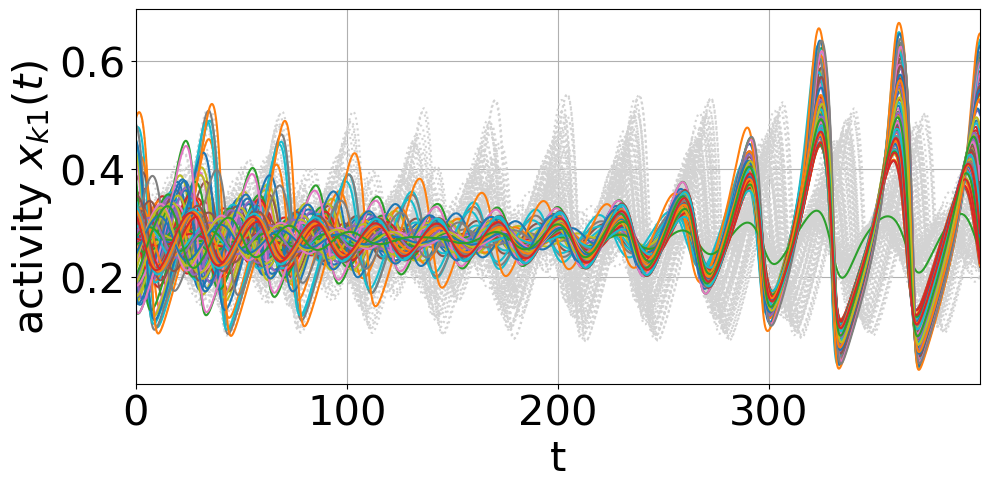

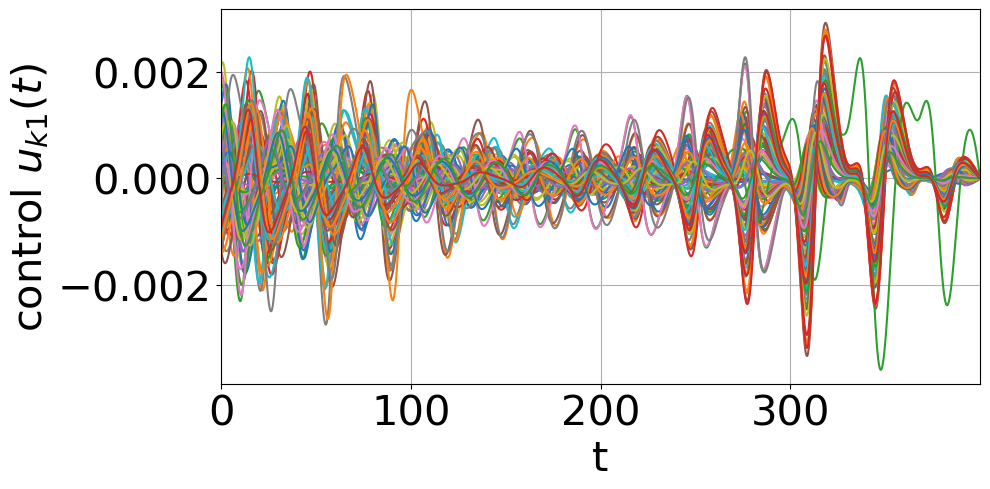

In [2]:
######################### PLOT THE RESULTS ############################


import matplotlib.pyplot as plt
from pylab import figure, cm


#calculate the controlled and uncontrolled state
control=control.reshape(tsteps,parameters['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control, **args)
nocontrol=np.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

#make plot
fs=30 #fontsize
i=-1
# PLOT NETWORK STATE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=np.min(state_controlled[:,0,:])
maxx=np.max(state_controlled[:,0,:])
add=(maxx-minn)/25
im1=ax.plot(np.arange(0,int(T),dt),state_uncontrolled[:,0,:],color='lightgray',linestyle='dotted')
ax.plot(np.arange(0,int(T),dt),state_controlled[:,0,:])
ax.set_xlabel('t',size=fs)
ax.set_ylabel('activity $x_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Network state',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()


# PLOT CORRESPONDING OPTIMAL CONTROL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=np.min(control)
maxx=np.max(control)
add=(maxx-minn)/25

im1=ax.plot(np.arange(0,int(T),dt),control)
ax.set_xlabel('t',size=fs)
ax.set_ylabel('control $u_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Control',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()




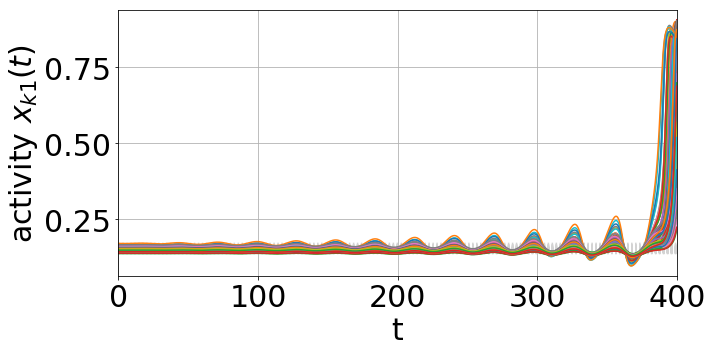

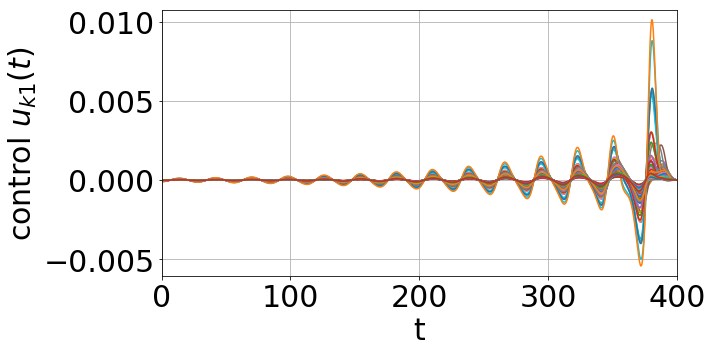

In [4]:
######################### PLOT THE RESULTS ############################


import matplotlib.pyplot as plt
from pylab import figure, cm


#calculate the controlled and uncontrolled state
control=control.reshape(tsteps,parameters['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control, **args)
nocontrol=np.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

#make plot
fs=30 #fontsize
i=-1
# PLOT NETWORK STATE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=np.min(state_controlled[:,0,:])
maxx=np.max(state_controlled[:,0,:])
add=(maxx-minn)/25
im1=ax.plot(np.arange(0,int(T),dt),state_uncontrolled[:,0,:],color='lightgray',linestyle='dotted')
ax.plot(np.arange(0,int(T),dt),state_controlled[:,0,:])
ax.set_xlabel('t',size=fs)
ax.set_ylabel('activity $x_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Network state',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()


# PLOT CORRESPONDING OPTIMAL CONTROL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=np.min(control)
maxx=np.max(control)
add=(maxx-minn)/25

im1=ax.plot(np.arange(0,int(T),dt),control)
ax.set_xlabel('t',size=fs)
ax.set_ylabel('control $u_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Control',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()


